# Optimal Execution : Algrem Chriss Algorithm

In this notebook, we implement the optimal execution algorithm of Algrem Chriss to minimize the volatility risk and transactions costs that come from temporary and permanent market impact.

Say we want to sell large amount $X$ shares of an asset of price $S_t$ between time $0$ and time $T$ We first discretize the time line by : $\tau = \frac{T}{N}$ and $t_k = k\times\tau$

Let $x_k$ the number of shares that remain in our portfolio at time $t_k$ et let $n_k$ le number of shares that we decide to sell on the period $[t_{k-1},t_k]$

In particular we have the two conditions : 

- $x_0 = X$ (initial number of shares to sell)
- $x_N = 0$ (final number of share so sell : 0, because everything has be sold)

We assume that the asset $S_t$ as the following dynamic : $S_k = S_{k-1} + \sigma \sqrt{\tau} \xi_k$ where $\xi_k \sim \mathcal{N}(0,1)$

- Where $\sigma$ is the volatility of the model.

However, when we sell an amount $n_k$ on the market, we should take into account the temporary and permanent impact on the price that comes from our order

We model them by :

- A linear permanent market impact by a function $g(\frac{n_k}{\tau}) = \gamma \frac{n_k}{\tau}$
- A affine temporary market impact by a function $h(\frac{n_k}{\tau}) = \epsilon + \eta \frac{n_k}{\tau}$

Where :

- $\gamma$ is the permanent impact parameter. We assume linear permanent market impact on the price of the asset

- $\eta, \epsilon$ are the temporary market impact parameters that reflect microstructure effect.  


By modelling the permanent and temporray market impact this way, we end up the following dynamic for the asset price:

$$S_k = S_{k-1} + \sigma\sqrt{\tau}\xi_k - g(\frac{n_k}{\tau}) - h(\frac{n_k}{\tau})$$


$$S_k = S_{k-1} + \sigma\sqrt{\tau}\xi_k - \gamma \frac{n_k}{\tau} - \epsilon - \eta \frac{n_k}{\tau}$$

The result of the sell of the asset is : 
$$\sum^N_{k=1} n_k S_k = \sum^N_{k=1} (x_{k-1} - x_k) S_k $$

$$=  x_0S_0 +  \sum^N_{k=1} (x_{k-1} S_{k}) - \sum^{N}_{k=1} (x_{k-1} S_{k-1}) $$

$$ = XS_0 + \sum^N_{k=1} \left( \sigma\sqrt{\tau} \xi_k -\tau g(\frac{n_k}{\tau})\right)x_k - \sum^N_{k=1} n_k h(\frac{n_k}{\tau})$$




so that we want to minimize the trading cost in comparison to selling $X$ shares immediatly at $t=0$ and price $S_0$

This gives the following function minimize : 

$$\mathcal{C} = XS_0 - \sum^N_{k=1} n_k S_k$$

$$\mathcal{C} = \sum^N_{k=1} \left( -\sigma\sqrt{\tau} \xi_k +\tau g(\frac{n_k}{\tau})\right)x_k + \sum^N_{k=1} n_k h(\frac{n_k}{\tau})$$


We want to minimize for a given risk aversion parameter $\lambda$:

$$J_{\lambda} = \mathbb{E}(\mathcal{C}) + \lambda \mathbb{V}(\mathcal{C})$$

$$J_{\lambda} = \left(  \sum^N_{k=1} \tau x_k g(\frac{n_k}{\tau})+ \sum^N_{k=1} n_k h(\frac{n_k}{\tau}) \right )+ \lambda \left( \sigma^2 \sum^N_{k=1} \tau x^2_k \right) $$

By replacing the expression of $g$ and $h$ :


$$J_{\lambda} = \frac{1}{2} \gamma X^2 + \epsilon X + \frac{\tilde{\eta}}{\tau} \sum^N_{k=1}(x_{k-1}-x_k)^2 - \lambda \left( \sigma^2 \sum^N_{k=1} \tau x_k^2\right)$$

where $\tilde{\eta} = \eta - \frac{1}{2} \gamma \tau$

By taking the derivative with regard to every $x_j$ and setting them to $0$, we get:

$$\frac{\partial J\lambda}{\partial x_j} = 0 $$

$$x_{j-1} -2x_j + x_{j+1} = \tilde{K} x_j \tau^2$$

where $\tilde{K} = \lambda \sigma^2 / \tilde{\eta}$

Further computations lead to :

$$\fbox{$x_j = \frac{sinh(K(T-t_j))}{sinh(KT)}X$}$$

where $K = \frac{1}{\tau} arccosh(\frac{\tilde{K}^2\tau^2}{2}+1)$

# Algrem Chriss Implementation :

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
X = 1000
T =1
N = 1000
time = np.linspace(0, T, N)
dt = time[1] - time[0]


In [3]:
def solve_algrem_chriss(X, gamma, eta, sigma, lamda, N):
    x_list = []
    for k in range(N):
        t_k = k * dt

        eta_tilde = eta - 0.5 * gamma * dt
        K_tilde = lamda * sigma **2 /eta_tilde
        K = np.arccosh(0.5 * K_tilde * dt**2 +1)/dt

        x = (np.sinh(K * (T - t_k)) / np.sinh(K *T)) * X
        x_list.append(x)

    return x_list


# One example

We provide below an example just to see if the code works

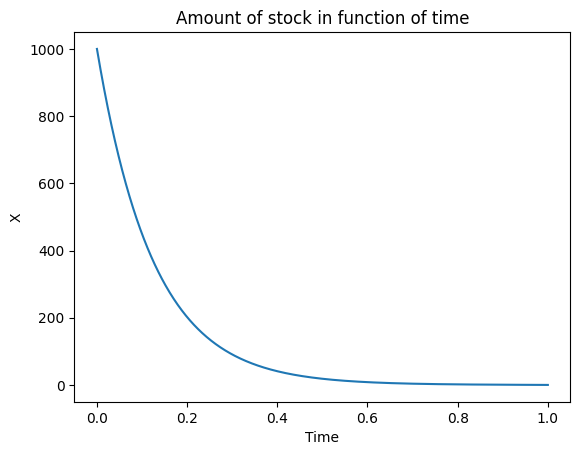

In [4]:
lamda_ref = 10**(-6)
sigma_ref = 80
gamma_ref = 0.00001
eta_ref = 0.0001

x_list = solve_algrem_chriss(X, gamma_ref, eta_ref, sigma_ref, lamda_ref, N)
n_list = np.diff(x_list)
plt.plot(time, x_list)
plt.xlabel('Time')
plt.ylabel('X')
plt.title('Amount of stock in function of time')
plt.show()


# Sensitivities

## - With regard to $\lambda$ (risk aversion parameter).

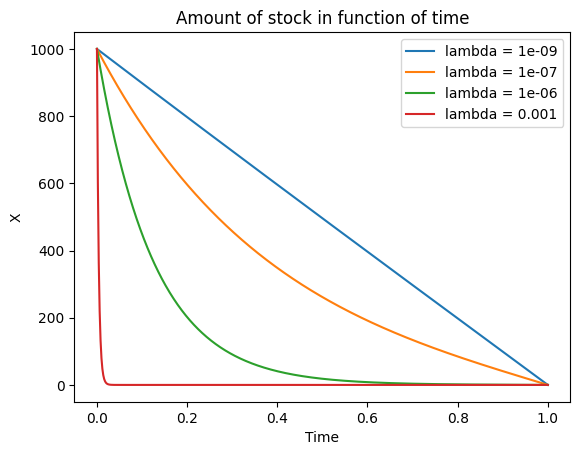

In [5]:
lambda_list = [10**(-9) ,10**(-7), 10**(-6), 10**(-3)]

for lamda in lambda_list:
    x_list = solve_algrem_chriss(X, gamma_ref, eta_ref, sigma_ref, lamda, N)

    plt.plot(time, x_list, label = 'lambda = {}'.format(lamda))
plt.xlabel('Time')
plt.ylabel('X')
plt.title('Amount of stock in function of time')
plt.legend()
plt.show()


As $\lambda$ approaches 0, the optimal liquidation strategy tends to be the regular one in which the trader sells equal amount of stock at each date $t_k$

As $\lambda$ increases (meaning that the trader is affraid of risk) the optimal strategy consists of selling everything immediatly at time $t_0$ (Doing that cost a lot due to bigger market impact)

# - With regard to $\eta$ (temporary market impact parameter).

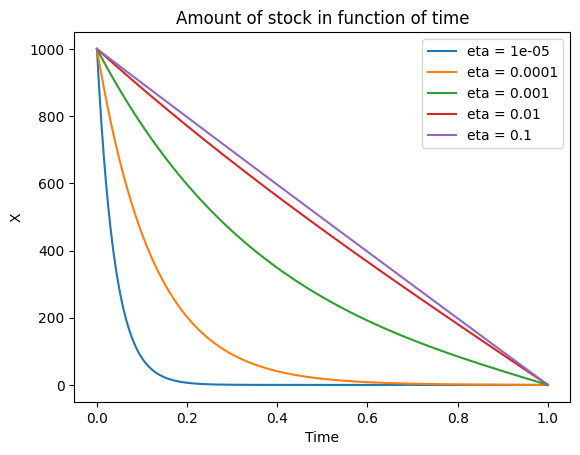

In [6]:
eta_list = [10**(-5), 10**(-4), 10**(-3), 10**(-2), 10**(-1)]

for eta in eta_list:
    x_list = solve_algrem_chriss(X, gamma_ref, eta, sigma_ref, lamda_ref, N)

    plt.plot(time, x_list, label = 'eta = {}'.format(eta))
plt.xlabel('Time')
plt.ylabel('X')
plt.title('Amount of stock in function of time')
plt.legend()
plt.show()

- As $\eta$ increases (meaning that the temporary market impact increases), the optimal liquidation strategy tends to be the regular one in which the trader sells equal amount of stock at each date $t_k$

- As $\eta$ decreases, (meaning that there is less and less temporary market impact), the optimal liquidation strategy consists of selling greater amount of shares at the beginning to avoid volatility risk

# - With regard to $\gamma$ (permanent market impact parameter).

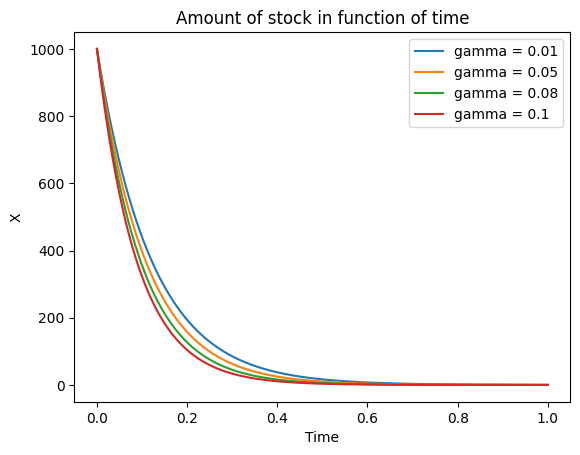

In [7]:
gamma_list = [0.01, 0.05, 0.08, 0.1]

for gamma in gamma_list:
    x_list = solve_algrem_chriss(X, gamma, eta_ref, sigma_ref, lamda_ref, N)

    plt.plot(time, x_list, label = 'gamma = {}'.format(gamma))
plt.xlabel('Time')
plt.ylabel('X')
plt.title('Amount of stock in function of time')
plt.legend()
plt.show()

- As $\gamma$ increases, the optimal strategy consists of selling more stock shares at earlier dates. Indeed, a high $\gamma$ means a large permanent market impact. Therefore, as the permanent market impact increases, it is better to execute selling order instead of holding them with prices that are impacted accross time. 

# Conclusion :

The Algrem Chriss algorithm is designed for optimal liquidation

It aims to minimize the impact of selling a large volume of assets on the market.

It determines the optimal selling strategy that reduces transactions costs by considering various factors such as market volatility, permanent and temporary market impact

In summary, Algrem Chriss provides a systematic approach to executing liquidations in an efficient and controlled manner.